In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys

sys.path.append('../..')
from sklearn.tree import DecisionTreeRegressor
from copy import deepcopy
import imodels
from viz import *
import plotly.graph_objects as go
from tqdm import tqdm

mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

# look at model example

In [2]:
def plot_sim(n=50, std=1, reg_param=0, show=True, linear_data=False, return_curves=False):
    np.random.seed(13)

    if linear_data:
        def gt_func(X):
            return X
    else:
        def gt_func(X):
            return +1 * (X < 2) * (X < 1) + \
                   -0 * (X < 2) * (X > 1) + \
                   +1 * (X >= 2) * (X < 3) + \
                   +0 * (X >= 2) * (X > 3)

    # data to fit
    X = np.random.uniform(0, 4, n)
    X = np.sort(X)
    y = gt_func(X) + np.random.normal(0, 1, n) * std


    # data to plot
    X_tile = np.linspace(0, 4, 400)
    y_tile = gt_func(X_tile)

    m1 = DecisionTreeRegressor(random_state=1)  #, max_leaf_nodes=15)
    m1.fit(X.reshape(-1, 1), y)
    y_pred_dt = m1.predict(X_tile.reshape(-1, 1))

    mshrunk = imodels.ShrunkTreeRegressor(deepcopy(m1), reg_param=reg_param)
    y_pred_shrunk = mshrunk.predict(X_tile.reshape(-1, 1))
    
    
    plt.plot(X, y, 'o', color='black', ms=4, alpha=0.5, markeredgewidth=0)    
    plt.plot(X_tile, y_tile, label='Groundtruth', color='black', lw=3)    
    plt.plot(X_tile, y_pred_dt, '-', label='CART', color=cb, alpha=0.5, lw=4)
    plt.plot(X_tile, y_pred_shrunk, label='CART (HTS)', color='#ff4b33', alpha=0.5, lw=4)
    plt.xlabel('X')
    plt.ylabel('Y')
    dvu.line_legend(adjust_text_labels=False)
    if show == 'save':
        plt.savefig(f'gif/{reg_param}.svg')
    elif show == 'pass':
        pass
    elif show:
        plt.show()
    else:
        plt.close()

    if return_curves:
        return X, y, X_tile, y_tile, y_pred_dt, y_pred_shrunk

#     print('dt', export_text(m1, feature_names=['X']))
#     print('dt', export_text(mshrunk.estimator_, feature_names=['X']))

# plot_sim(n=100)

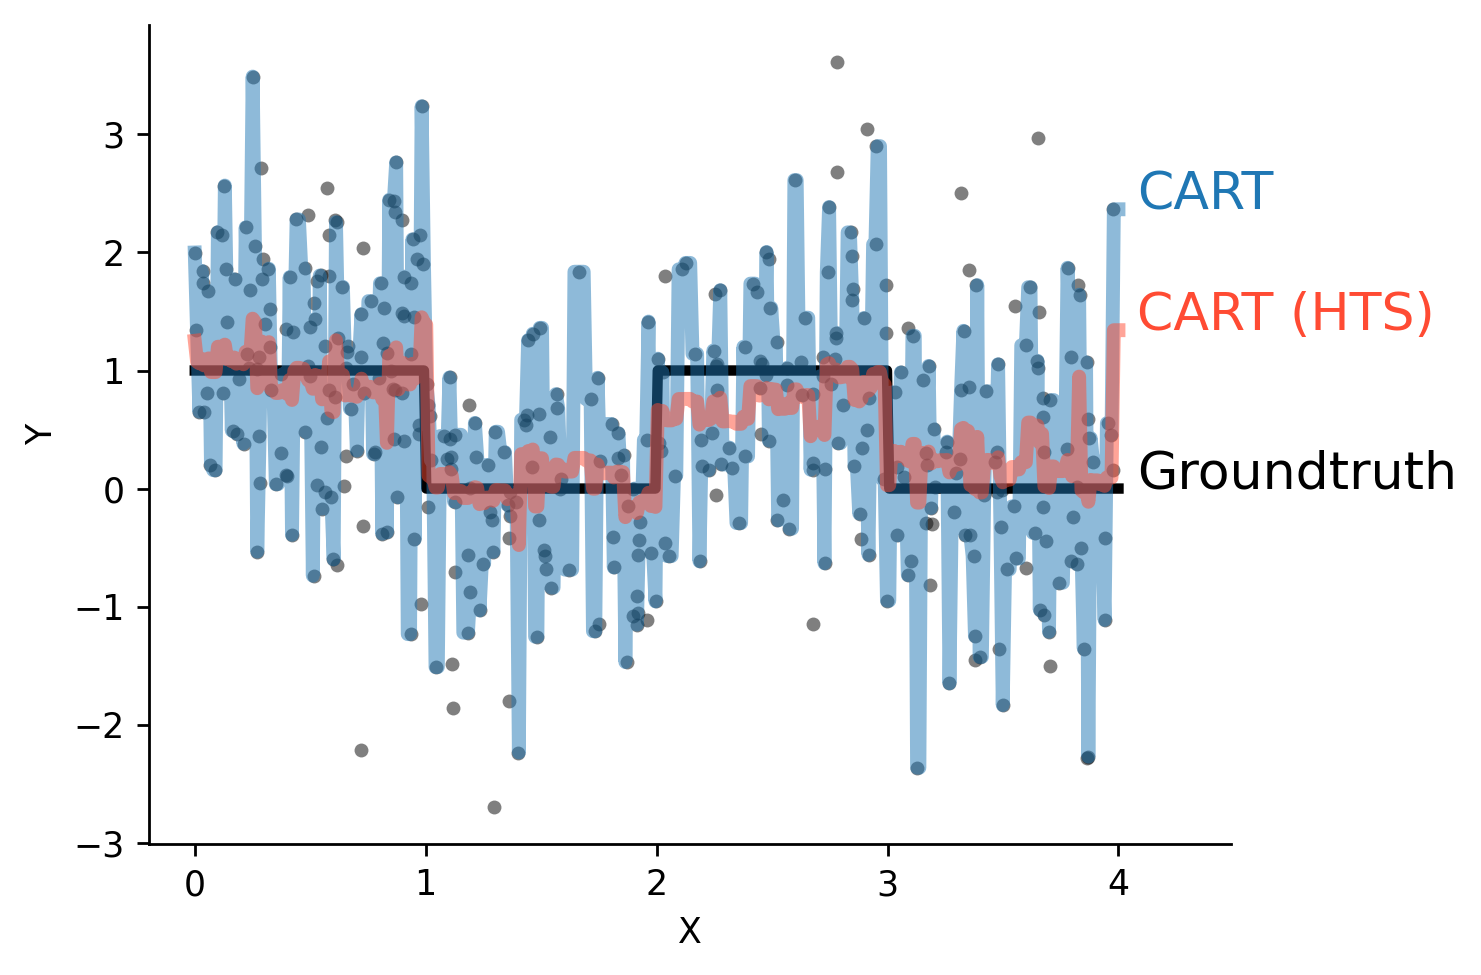

In [3]:
plot_sim(n=400, std=1, reg_param=100, show='pass')
plt.savefig('../../figs/intro_indicators.pdf')

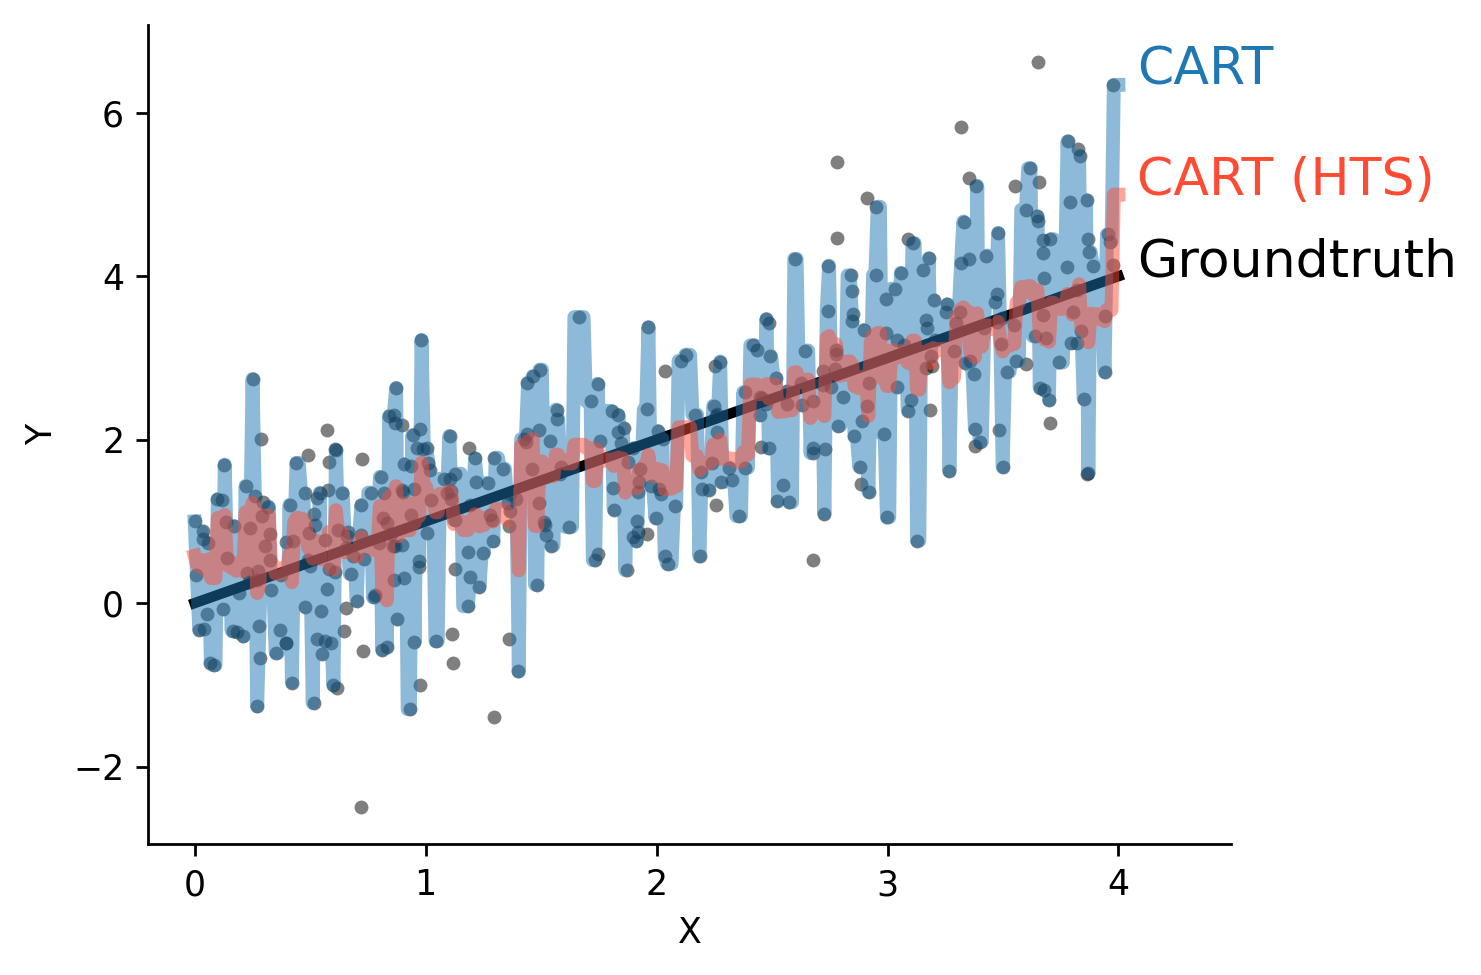

In [4]:
plot_sim(n=400, std=1, reg_param=50, linear_data=True, show='pass')
plt.savefig('../../figs/intro_linear.pdf')

# static interactive plotly plots
Note: requires installing plotly. To recreate, need to run this multiple times then copy the div that is printed out into demo_main.html

In [27]:
# generate data
n = 80
s = 0.6

linear_data = False
if linear_data:
    fname_out = 'shrinkage_linear.js'
else:
    fname_out = 'shrinkage_steps.js'

X, y, X_tile, y_tile, y_pred_dt, y_pred_shrunk = plot_sim(n=n, std=s, reg_param=0, linear_data=linear_data, 
                                                          show=False, return_curves=True)
# assert np.array_equal(y_pred_dt, y_pred_shrunk)
print(y_pred_dt[:30] - y_pred_shrunk[:30])
# print()
print(np.array_equal(y_pred_dt[:30], y_pred_shrunk[:30]))

# permanent curves to add
permanent_curves = [
    dict(name='Raw data points', x=X, y=y, mode='markers', line=dict(color=cb), visible=True),
    dict(name='Groundtruth', x=X_tile, y=y_tile, line=dict(color='black'), visible=True),
    dict(name='CART predictions', x=X_tile, y=y_pred_dt, line=dict(color='gray'), visible=True),
]

# active curve params
vary_curve_params = dict(name='Shrunk predictions', line=dict(color=cp), marker=dict(), visible=False)
vary_curves = []
vary_vals = [0, 1, 10, 30, 100] # what values to generate the curves for
for val in vary_vals:
    _, _, X_tile, _, _, y_shrunk = plot_sim(n=n, std=s, reg_param=val,
                                            show=False, linear_data=linear_data, return_curves=True)
    vary_curves.append(dict(x=X_tile, y=y_shrunk, **vary_curve_params))
    
    
active_curve = 2

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
True


In [28]:
# def create_slider_fig_static(permanent_curves, vary_curve_params, vary_curev_)
# Create figure
fig = go.Figure()
fig.layout.template = 'plotly_white'

# plot the permanent curves
for curve in permanent_curves:
    fig.add_trace(go.Scatter(**curve))

# Add traces, one for each slider step
for vary_curve in vary_curves:
    fig.add_trace(go.Scatter(**vary_curve))

# Create and add slider
steps = []
OFFSET = len(permanent_curves)
for i in range(len(fig.data) - OFFSET):  # remember offset
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)}],
#               {"title": "Reg-param: " + str(VALS[i])}],  # layout attribute
        label=str(vary_vals[i])
    )
    step["args"][0]["visible"][0:OFFSET] = [True] * OFFSET  # permanent curves    
    step["args"][0]["visible"][i + OFFSET] = True  # set i'th trace to "visible"
    steps.append(step)

fig.data[active_curve + OFFSET].visible = True # Make active_curve visible
sliders = [dict(
    active=active_curve,
    currentvalue={"prefix": "Regularization parameter: "},
    pad={"t": 50},
    steps=steps,
)]
fig.update_layout(sliders=sliders)

# write only what's needed
fig.write_html("demo.html", full_html=False, include_plotlyjs="cdn") # , 
s = (open('demo.html', 'r').read())
div_start = s.index('<div id=')
div_end = div_start + s[div_start:].index('</div>') + len('</div>')
print(s[div_start:div_end]) # print the div that needs to be copied elsewhere

js_start = s.rfind('<script type="text/javascript">') + len('<script type="text/javascript">')
js_end = js_start + s[js_start:].index('</script>')
with open(fname_out, 'w') as f:
    f.write(s[js_start:js_end])
os.remove('demo.html')
fig.show()

<div id="4db2fbb0-073d-492f-8f30-3e9fe37bf9f2" class="plotly-graph-div" style="height:100%; width:100%;"></div>


# ipywidget

In [ ]:
from ipywidgets.widgets import *

interactive_plot = interactive(plot_sim,
                               n=IntSlider(value=50, min=20, max=300, step=10),
                               std=FloatSlider(value=0.5, min=0.01, max=3),
                               reg_param=(0, 150))
output = interactive_plot.children[-1]
output.layout.height = '800px'
interactive_plot  # note this can't be exported to static

# try exporting to webpage
- ipywidgets doesn't support this properly
- bokeh requires writing JS code
- soln: save a bunch of svgs and then reopen them with a slider
    - ex: https://github.com/JanSellner/ImageSequenceAnimation
    - ```# save all images
for reg_param in [0, 1, 5, 10, 181]:
    plot_sim(reg_param=reg_param, show='save')
    plt.close()```
- soln: plotly can just store all the curves and then export